## Analysis of the Sample of the French Comedies

We will examine the 10% proportionate stratified random sample of the French 5-act verse comedies (29 comedies from different decades). 

We will explore the following questions:
1. The evolution of non-dialogues, monologues, and polylogues - does it make sense to combine monologues and polylogues into non-dialogues?
2. Determine potential boundaries between four periods using Euclidean distance;
3. Visualize the historical development of the features;
4. Run descriptive statistics for the each period.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load the previously taken sample
sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

In [3]:
sample_df.head()

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_51,Les Apparences trompeuses,Boisrobert,François Le Métel de,1655,0,5,NaN,12,45,...,43.18,6.288,1.002,7,15.909,NaN,NaN,NaN,1655,1660
1,F_54,Le Marquis ridicule,Scarron,Paul,1656,0,5,http://www.theatre-classique.fr/pages/document...,10,24,...,43.24,22.387,1.692,3,8.108,637.0,1654.0,0.385,1660,1660
2,F_212,La Belle-mère ou les Dangers d'un second mariage,Vigée,Louis-Jean-Baptiste-Étienne,1788,0,5,NaN,10,42,...,16.67,4.167,0.950,5,11.905,NaN,NaN,NaN,1790,1790
3,F_206,L'École des pères,Pieyre,Alexandre,1787,0,5,NaN,9,63,...,13.64,10.606,0.785,2,3.030,NaN,NaN,NaN,1790,1790
4,F_266,Le Faux bonhomme,Duval,Alexandre,1821,0,5,NaN,8,42,...,26.67,6.481,1.134,0,0.000,NaN,NaN,NaN,1825,1830


In [4]:
sample_df[sample_df['decades'].isin([1680, 1690])]

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
18,F_91,Les Nobles de Province,Hauteroche,"Noël Lebreton, sieur de",1678,0,5,http://www.xn--thtre-documentation-cvb0m.com/c...,19,75,...,44.74,14.081,1.281,4,5.263,NaN,NaN,NaN,1680,1680
22,F_97,Le Parisien,Champmeslé,NaN,1682,0,5,NaN,11,49,...,44.83,12.011,1.071,3,5.172,NaN,NaN,NaN,1685,1690


In [5]:
# rename features to make them more understandalbe
sample_df = sample_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                      'percentage_non_duologues': 'percentage_non_dialogues',
                                      'percentage_above_two_speakers': 'percentage_polylogues'})

In [6]:
sample_df.shape

(29, 25)

In [7]:
# sort by date
sorted_sample = sample_df.sort_values(by='date')

# Part 1. The percentage of Non-dialogues, Monologues, and Polylogues

We can't be sure that the evolution of monologues and polylogues justifies combining them into one feature, i.e., he percentage of non-dialogues as Iarkho does. We will examine the behavior of these features using visualizations.

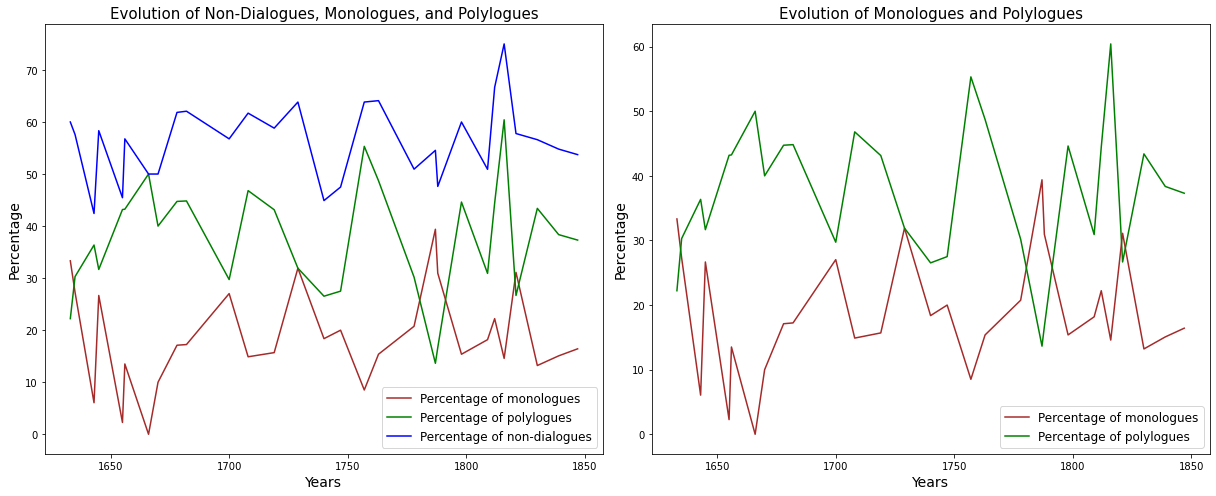

In [8]:
plt.figure(figsize=(17, 7))
plt.subplot(121)
plt.title('Evolution of Non-Dialogues, Monologues, and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_polylogues'], color='green', label='Percentage of polylogues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_non_dialogues'], color='b', label='Percentage of non-dialogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

plt.subplot(122)
plt.title('Evolution of Monologues and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_polylogues'], color='green', label='Percentage of polylogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.tight_layout()
plt.show()

Based on this visualization, the percentage of monologues is the mirrow image of the percentage of polylogues. We can check this by inspecting the correlation between them.

In [9]:
sorted_sample[['percentage_polylogues', 'percentage_monologues']].corr()

,percentage_polylogues,percentage_monologues
percentage_polylogues,1.000000,-0.748575
percentage_monologues,-0.748575,1.000000


It turns out that the percentage of monologues and the percentage of polylogues have a rather strong negative correlations ≈ -0.75. By combining the two features into one, i.e., the percentage of non-dialogues, we obsure the picture: we get a feature which barely evolves over the decades. Based on this analysis, we will treat the percentage of monologues and the percentage of polylogues separately.

# Part 2. Euclidean Distance Between Time Periods

### Number of Literary Periods

In his study of the evolution of the five-act tragedy, Boris Iarkho distinguished five time periods (including early Corneille, who was influenced by Barocco), mature Neoclassicism (the seventeenth century), late Neoclassicism (the eighteenth century), early (extreme) Romanticism, and late Romanticism. However, Iarkho's early Romantic period entirely consisted of German tragedies, whereas we focus on the French national tradition. Therefore, we hypothesize that the observed material will fall into **four periods**.

## Length of a Literary Period

We want analyze large cultural-historical trends, not temporary oscilations. Therefore, we decide to impose **a ten year minimum length** for a time period to qualify as a literary period. The shortest literary period identified by our predecessor Sperantov is 11 years (Russian Neo-Neoclassicism).

## Description of the Method

1. We will treat each comedy as a feature vector containing the following features: number of dramatic characters, mobility coefficient, the percentage of monologues, the percentage of polylogues, and the standard range of the number of speaking characters (sigma)
    - For example, Pierre Corneille's *La Suite du menteur* would become the feature vector [7, 33, 6.06, 36.36, 0.856].
2. Next, we will need to rescale the features. We will use the **Standard Scaler** from **sklearn Python library** . 
3. We will form potential time periods by iterating over **5-year** intervals for each boundary.
    - Based on our hypothesis, we set the number of time periods at **4** and the number of boundaries at 3 accordingly (the lower, middle, and upper boundary).
     - For each boundary, we itervate over **5-year intervals** making sure that each resulting time period is **at least 10 years long**, e.g., 1640, 1645, 1650 for the lower boundary.
    - Additionally, we want to make sure that each time period has enough data points (plays), therefore, we impose a condition that each time period should have **at least two comedies**.
 
4. For each potential time period, we create a summary vector, which is the sum of all the feature vectors of all the plays within this time period and normalize it.
    - For example, for a time period which has three comedies with feature vectors:
        - [0.06465290353730044, -0.30577420982741776, -1.789252485754977, 0.5390742808859644, -0.5645891156149813] 
        - [-0.3519991414808586, -0.827389038356542, -0.5657126358447828, 0.5446117343881878, 0.8215983940114943] 
        - [-0.1436731189717791, -2.0941679076415576, -2.0363552846247406, 1.1684981623053272, 0.6910155126698694]
         - We will sum up all these vectors into one period summary vector [-0.43101936, -3.22733116, -4.39132041,  2.25218418,  0.94802479]
        - Next, because time periods might have different number of plays, it is important to **normalize** period summary vectors. We will use the normalize function from **sklearn**, which will divide the vector by its l2 (or Euclidean norm). 
5. We calculate Euclidean distance between period summary vectors for all neighboring periods: between period one and two, two and three, three and four using **sklearn**. 
    - For example, the Euclidean distance between period one (1629 to 1650) and period two (1651 to 1695) is 1.87119452. The distance between period two and three (1696 and 1795) is 1.96540872, the distance between period three and four (1796 to 1847) is 1.75493729. We take the mean of these distances, which is 1.8638468404538342.
6. We iterate over all potential period boundaries and select such boundaries that produce the maximum mean Euclidean distance, i.e., have the largest average distance between the neighboring time periods.

### ADDITIONAL NOTES:

 - Standard Scaler turns each data point into **a standard score (z)** using the following formula: \begin{align*}z = (x - μ) / s \end{align*} where μ is the mean of the feature and s is the standard deviation of this feature. 
    - For example, μ for number of dramatic characters is 11.689655172413794 and standard deviation is 4.800168447301953. So, we will calculate it the following way (7 - 11.689655172413794) / 4.800168447301953 = -0.9769772090080973. This is exactly the score we get from the Standard Scaler. 
    - After rescaling all the features, the standardized feature vector for *La Suite du menteur* becomes [-0.9769772090080973, -1.1254546546588986, -1.3766887819151519, -0.09034960053339845, -0.8578983567823225]
 - **l2 norm** is calculated by $\sqrt{\sum_{i=1}^n (x_i^2)}$
     - We square all the values of the vector (e.g, $-0.431019362^2$, $-3.22733116^2$, $-4.39132041^2$, $2.25218418^2$, $0.94802479^2$). We end up with [0.18577769, 10.41566642, 19.28369494,  5.07233358,  0.898751]. 
     - Then, we add up all these values 0.18577769 + 10.41566642 + 19.28369494 + 5.07233358 + 0.898751 and get 35.85622363138114. Finally, we take $\sqrt{35.85622363138114}$, which is 5.98800664924323. 
     - We divide the summary vector [-0.43101936, -3.22733116, -4.39132041,  2.25218418,  0.94802479] by $35.85622363138114$ and arrive at the normalized vector [-0.07198044, -0.53896586, -0.73335263,  0.37611584,  0.1583206].
     
 - "**The Euclidean distance** is the straight line distance between two points in Euclidean space." The formula is \begin{align*}d(x, y)= \sqrt{\sum_{i=1}^n (x_i - y_i)^2} \end{align*}
     - Source: National Institute of Standards and Technology."Euclidean Distance." Statistical Engineering Division. Last modified July 10, 2017. Accessed September 2, 2020. https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/eucldist.htm)
     - For example, to calculate the Euclidean distance between two vectors:
     - x = [-0.53897687, -0.35108778,  0.44314966, -0.58493814, -0.21841945] and 
     - y = [0.47223737, -0.2484047, -0.56245228,  0.38393381, 0.5015269], we would do the following: 
   $\sqrt{(-0.53897687 -0.47223737)^2+(-0.35108778-(-0.2484047))^2 + (0.44314966 -(-0.56245228))^2 + (-0.58493814 - 0.38393381)^2 + (-0.21841945 - 0.5015269)^2}$ 
     d(x, y) = 1.8711945172474937$

In [10]:
def determine_period(row, lower, middle, upper):
    """
    The function creates a column corresponding to time periods.
    Params:
        row - a row with the date
        lower - upper boundary of period one
        middle - upper boundary of period two
        upper - lower boundary of period three
    Returns:
        int - either 1, 2, 3, or 4 corresponding to the time period.
    """
    if row <= lower:
        period = 1
    elif row > lower and row <= middle:
        period = 2
    elif row > middle and row <= upper:
        period = 3
    else:
        period = 4
        
    return period

In [11]:
def create_time_period_vectors(df, features, num_time_periods):
    """
    The function creates the period summary vectors by taking the sum of the play vectors and normalizing the result.
    Params:
        df - dataframe with the data
        features - a list with the names of the features
        num_time_periods - int, a number of time periods we are expecting
    Returns:
        time_periods - a list of tuples where the first element is the summary vector 
                        and the second element is the number of data points in the period.
    """
    time_periods = []
    for period in range(1, num_time_periods + 1):
        # take the sum of the vectors of each period and normalize the summary vector
        period_df = normalize(df[df.period == period][features].sum().values.reshape(1, -1))
        # append a tuple with the normalized summary and the number of data points in each period
        time_periods.append((period_df, df[df.period == period].shape[0]))
        
    return time_periods

In [12]:
def calculate_mean_distance(summary_vector_tuples):
    """
    The function calculates the Euclidean distances between all adjacent time periods and takes the mean.
    Params:
       summary_vecot_tuples - output of the create_time_period_vectors function.
    Returns:
        mean_distance - float, the mean Euclidean distance between adjacent periods.
    """
    distances = []
    for record in range(0, len(summary_vector_tuples) - 1):
        dist = euclidean_distances(summary_vector_tuples[record][0],
                                   summary_vector_tuples[record + 1][0])
        distances.append(dist[0])
    mean_distance = np.mean(distances) 
    
    return  mean_distance

In [13]:
def identify_boundaries(sample_df, features):
    """
    The function iterates over 5-year intervals and computes the mean Euclidean distance between adjacent periods.
    It identifies the boundaries that produce the maximum Euclidean distance.
    Params:
        sample_df - dataframe with the sample data
        features - - a list with the names of the features
    Returns:
        distances - a list of tuples that contain the maximum Euclidean distance as well as 
                    the lower, middle, and upper boundaries for four time periods.
        
    """
    distances = []
    for lower in range(1640, 1816, 5):
        for middle in range(1650, 1826, 5):
            for upper in range(1660, 1836, 5):
                # make sure that each consequtive boundary is higher than the previous and the legnth of each e
                # period is at least 10 years
                if middle > lower and upper > middle and (middle - lower) >= 10 and (upper - middle) >= 10:
                    sample_df['period'] = sample_df['date'].apply(determine_period, args=[lower, middle, upper])
                    # return tuples containing summary vectors for each period with the number of data points in each
                    summary_vector_tuples = create_time_period_vectors(sample_df, features, 4)
                    # make sure that each period has at least two records
                    if len([record[1] for record in summary_vector_tuples if record[1] < 2]) == 0:
                        mean_distance = calculate_mean_distance(summary_vector_tuples)
                        distances.append((mean_distance, lower, middle, upper))
                        
    # return the potential boundaries with the maximum distance
    result = [dist for dist in distances if dist[0] == np.max([d[0] for d in distances])]                    
    
    return result

## Rescale the Features Using Standard Scaler

In [14]:
# rescale the feautures using StandardScaler to be able to calculate Euclidean distance
scaler = StandardScaler(with_mean=True, with_std=True)
# define the features
features = ['num_present_characters', 
            'mobility_coefficient',
            'percentage_monologues',
            'percentage_polylogues',
            'sigma_iarkho']
sorted_sample_copy = sorted_sample.copy()
rescaled_features = scaler.fit_transform(sorted_sample_copy[features])

sorted_sample_copy[features] = rescaled_features

## Calculate the period boundaries which produce the largest mean Euclidean distance

In [15]:
result = identify_boundaries(sorted_sample_copy, features)

In [16]:
for res in result:
    print('Euclidean distance:', res[0], 'The end of period one:', res[1], 'The end of period two:', res[2],
          'The end of period three:', res[3])

Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1685 The end of period three: 1790
Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1685 The end of period three: 1795
Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1690 The end of period three: 1790
Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1690 The end of period three: 1795
Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1695 The end of period three: 1790
Euclidean distance: 1.8638468404538342 The end of period one: 1645 The end of period two: 1695 The end of period three: 1795
Euclidean distance: 1.8638468404538342 The end of period one: 1650 The end of period two: 1685 The end of period three: 1790
Euclidean distance: 1.8638468404538342 The end of period one: 1650 The end of period two: 1685 The end of period three: 1795


## Are there any records between those alternative dates?

There is one record in our sample dating back to 1645. However, since we are making our boundaries inclusive, it will belong to the first time period regardless whether the lower boundary is set at 1645 or 1650. In other instances, there are no records between the alternative dates.

In [17]:
sorted_sample[(sorted_sample['date'] >=1645)&(sorted_sample_copy['date'] <=1650)]

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_polylogues,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
11,F_29,Jodelet ou Le Maître Valet,Scarron,Paul,1645,0,5,http://www.theatre-classique.fr/pages/document...,8,60,...,31.67,7.294,1.077,7,11.667,582.0,1857.0,0.313,1645,1650


In [18]:
sorted_sample[(sorted_sample['date'] >1685)&(sorted_sample_copy['date'] <=1695)]

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_polylogues,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades


In [19]:
sorted_sample[(sorted_sample['date'] >1790)&(sorted_sample_copy['date'] <=1795)]

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_polylogues,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades


Based on this analysis, the choice between 1645  vs. 1650, 1685 vs. 1690 vs. 1695, and 1790 vs. 1795 is equivalent. For convenience purposes, we will select the higher boundary in each case.

## Proposed Periodization

We hypothesize that the comedies fall into the following time periods:
1. From 1629 to 1650
2. From 1651 to 1695
3. From 1696 to 1795
4. From 1796 to 1847

# Part 3. Visualizations of the Features and Time Periods

We will create scatterplots joint with kernel density plots for each feature and display period boundaries with dashed lines.

    Note: "The goal of density estimation is to take a finite sample of data and to make inferences about the underlying probability density function everywhere, including where no data are observed. In kernel density estimation, the contribution of each data point is smoothed out from a single point into a region of space surrounding it. Aggregating the individually smoothed contributions gives an overall picture of the structure of the data and its density function." (Wikipedia."Multivariate kernel density estimation." Accessed September 2, 2020. https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation)

In [20]:
def scatter(df, feature, title, xlabel):
    sns.jointplot('date', 
               feature,
               data=df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=30)
    
    plt.axvline(1650, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1695, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
    plt.title(title, fontsize=20, pad=100)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(xlabel, fontsize=14)

    plt.show()

## Number of Dramatic Characters

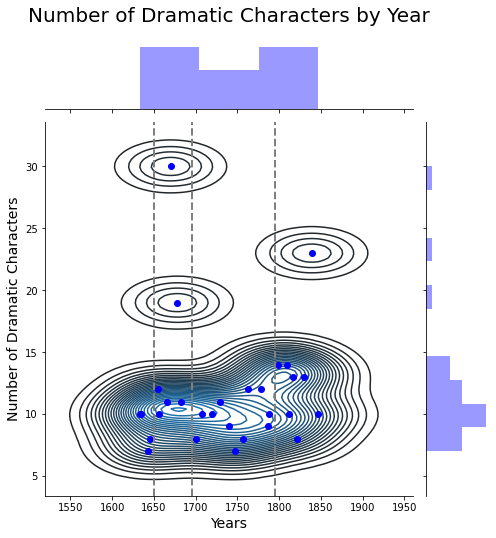

In [21]:
scatter(sample_df, 
        'num_present_characters', 
        'Number of Dramatic Characters by Year', 
        'Number of Dramatic Characters')

## Mobility Coefficient

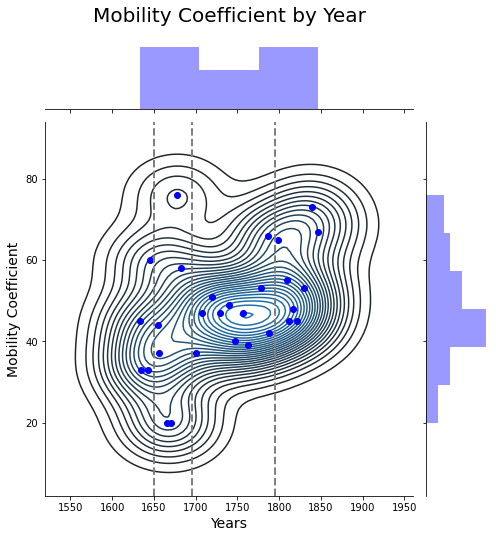

In [22]:
scatter(sample_df, 
        'mobility_coefficient', 
        'Mobility Coefficient by Year', 
        'Mobility Coefficient')

## Standard Range of the Speaking Characters (Sigma)

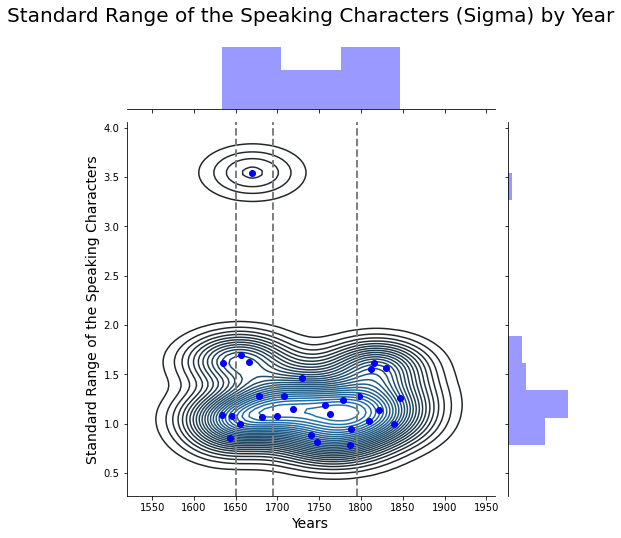

In [23]:
scatter(sample_df, 
        'sigma_iarkho', 
        'Standard Range of the Speaking Characters (Sigma) by Year', 
         'Standard Range of the Speaking Characters')

## Percentage of Non-Dialogues

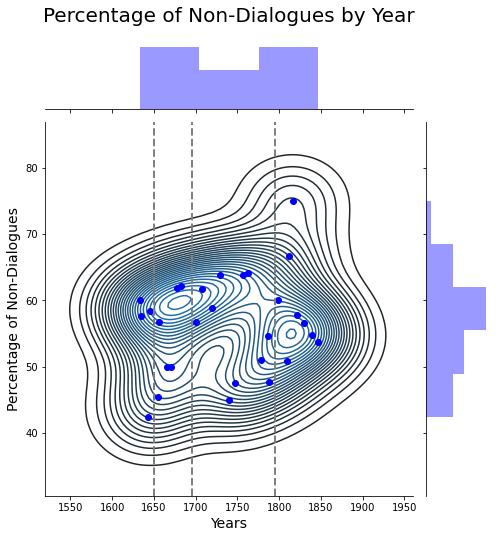

In [24]:
scatter(sample_df, 
        'percentage_non_dialogues', 
        'Percentage of Non-Dialogues by Year', 
        'Percentage of Non-Dialogues')

## Percentage of Polylogues

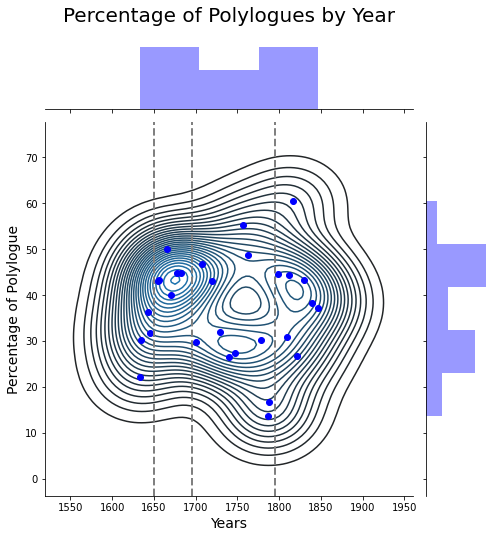

In [25]:
scatter(sample_df, 
        'percentage_polylogues', 
        'Percentage of Polylogues by Year', 
        'Percentage of Polylogue')

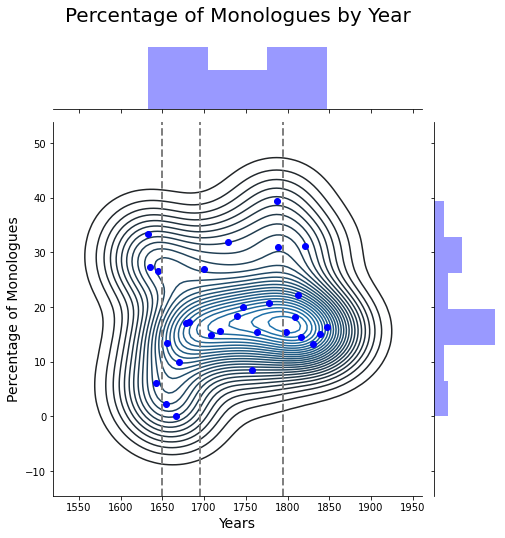

In [26]:
scatter(sample_df, 
        'percentage_monologues', 
        'Percentage of Monologues by Year', 
        'Percentage of Monologues')

Based on the plots, the proposed boundaries seem to be a reasonable reflection of the natural clustering of the datapoints, at least for such features as the number of dramatic characters, mobility coefificnet, the standard range of the number of speaking characters, and the percentage of polylogues.

# Part 4. Descriptive Statistics by Periods (Based on the Sample)

In [27]:
sorted_sample['period'] = sorted_sample['date'].apply(determine_period, args=[1650, 
                                                                              1695, 
                                                                              1795])

## Number of Dramatic Characters

In [28]:
sorted_sample.groupby('period').describe().loc[:, 'num_present_characters'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,8.750000,1.500000,9.0,7.0,10.0
2,15.500000,7.816649,11.5,10.0,30.0
3,9.636364,1.629278,10.0,7.0,12.0
4,13.125000,4.549333,13.0,8.0,23.0


## Mobility Coefficient

In [29]:
sorted_sample.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,42.750000,12.816006,39.0,33.0,60.0
2,42.500000,21.943108,40.5,20.0,76.0
3,47.090909,8.092645,47.0,37.0,66.0
4,56.375000,10.729632,54.0,45.0,73.0


## Sigma

In [30]:
sorted_sample.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,1.159500,0.321007,1.0845,0.856,1.613
2,1.702667,0.944500,1.4540,1.002,3.543
3,1.083545,0.208814,1.1000,0.785,1.460
4,1.304375,0.245199,1.2720,1.000,1.610


## Percentage of Non-Dialogues

In [31]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,54.582500,8.171179,57.955,42.42,60.00
2,54.353333,6.907410,53.380,45.45,62.07
3,55.868182,7.228051,56.760,44.90,64.10
4,59.435000,7.860467,57.190,50.91,75.00


## Percentage of Polylogues

In [32]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,30.137500,5.881646,30.985,22.22,36.36
2,44.331667,3.281051,43.990,40.00,50.00
3,33.650909,13.294896,30.190,13.64,55.32
4,40.766250,10.247927,40.880,26.67,60.42


## Percentage of Monologues

In [33]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_monologues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,23.332500,11.901430,26.970,6.06,33.33
2,10.021667,7.416736,11.755,0.00,17.24
3,22.079091,9.169879,20.000,8.51,39.39
4,18.271250,5.876229,15.900,13.21,31.11


### Summary:

- For the **number of the dramatic characters** and **standard range of the number of speaking characters** (sigma), both the median and standard deviation is consistently higher in period two than in period one and in period four than period three for such features as:


- The opposite is true for **the percentage of monologues**: the median and the standard deviation are higher in period one than in period two, and in period three than in period four.

- **The percentage of polylogues** reveals a somewhat more complex pattern: the median is higher in period two than in period one and in period four than period three. However, the opposite is true about the standard deviation, it is higher in period one than in period two, and in period three than in period four.  

- The median **mobility coefficient** keeps rising from period one through four, however, its standard deviation is not constant, it is higher in period two than in period one and in period four than in period three.

# Conclusion:

1. The percentage of non-dialogues should be split into two separate features: the percentage of monologues and the percentage of polylogues as their behavior is reversed (they have a strong negative correlation of ≈ -0.75.
2. Based on our exploration of the sample data, we hypothesize that the comedies fall into the following time periods:
    - Period one: from 1629 to 1650
    - Period two: from 1651 to 1695
    - Period three: from 1696 to 1795
    - Period four: from 1796 to 1847

2. Period two and four are characterized by higher variance in such features as the number of dramatic characters, standard range of the number of speaking characters (sigma),and mobility coefficient.
3. The median mobility coefficient keeps rising from period one through four, i.e., the pace of comedy is accelerating.